In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

# Load and inspect data

In [2]:
df = pd.read_csv("data/data-conc-2.txt")
print(len(df))
df.head(20)

16


,PersonID,Time1,Time2,Time4,Time8,Time12,Time24
0,1,2.4,5.0,7.5,11.9,12.5,12.7
1,2,1.4,3.9,4.4,7.7,6.4,8.3
2,3,5.2,9.4,19.4,20.2,22.7,24.9
3,4,6.7,12.6,19.1,23.4,25.8,26.1
4,5,0.3,4.7,7.0,10.2,12.9,14.8
5,6,6.3,3.8,11.8,9.2,13.9,18.2
6,7,3.0,4.2,8.8,15.4,10.7,16.2
7,8,6.2,6.8,9.4,11.3,12.4,14.7
8,9,14.4,17.0,22.7,29.8,33.0,32.2
9,10,7.7,10.0,14.8,15.3,18.0,18.7


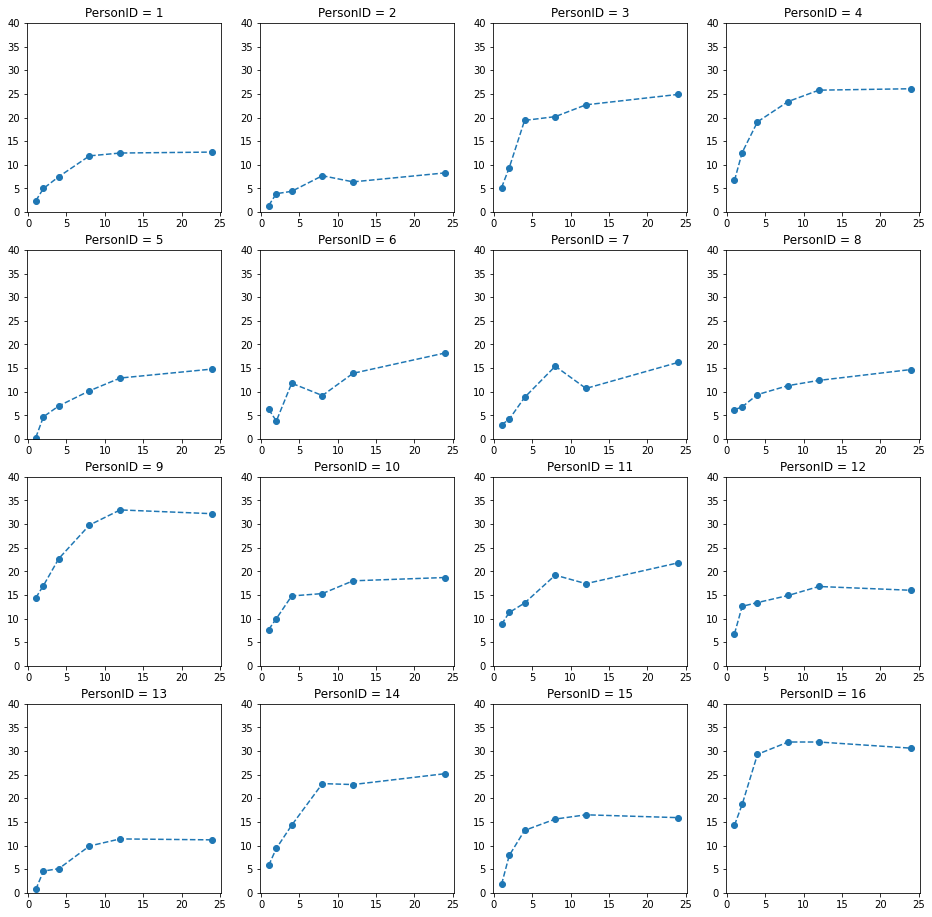

In [3]:
# Fig 8.7 left

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

for i, ax in enumerate(np.ravel(axes)):
    ax.plot([1, 2, 4, 8, 12, 24], df.iloc[i].values[1:], 'o--')
    ax.set_title(f"PersonID = {i+1}")
    ax.set_ylim(0, 40)
    
fig.show()

<AxesSubplot:xlabel='Time24', ylabel='Density'>

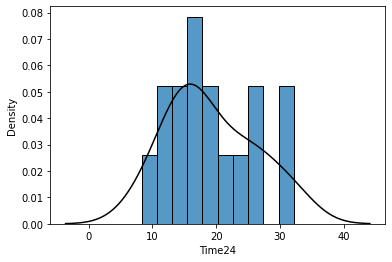

In [4]:
# Fig 8.8 right
ax = plt.subplot(1, 1, 1)
sns.histplot(ax=ax, stat="density", x=df["Time24"], bins=10)
sns.kdeplot(ax=ax, x=df["Time24"], color='k')

# Run stan

In [5]:
model = CmdStanModel(stan_file="model/model8-7.stan")
print(model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap08/model/model8-7


CmdStanModel: name=model8-7
	 stan_file=/workdir/chap08/model/model8-7.stan
	 exe_file=/workdir/chap08/model/model8-7
	 compiler_optons=stanc_options=None, cpp_options=None


In [6]:
Time = [1, 2, 4, 8, 12, 24]
Time_new = np.linspace(0, 24, 61)

data = {
    "N": len(df),
    "T": 6,
    "Time": Time, 
    "Y": df.iloc[:, 1:].values,
    "T_new": 61,
    "Time_new": Time_new
}

In [7]:
fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


In [8]:
# check convergence
summary = fit.summary()
summary[summary["R_hat"] >= 1.1 ]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [9]:
# check convergence
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmp5te9pfjh/model8-7-202010010527-1-w7cullx6.csv, /tmp/tmp5te9pfjh/model8-7-202010010527-2-cm_up95z.csv, /tmp/tmp5te9pfjh/model8-7-202010010527-3-mply8g3r.csv, /tmp/tmp5te9pfjh/model8-7-202010010527-4-hepat9rb.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 4000 (0.025%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


Processing csv files: /tmp/tmp5te9pfjh/model8-7-202010010527-1-w7cullx6.csv, /tmp/tmp5te9pfjh/model8-7-202010010527-2-cm_up95z.csv, /tmp/tmp5te9pfjh/model8-7-202010010527-3-mply8g3r.csv, /tmp/tmp5te9pfjh/model8-7-202010010527-4-hepat9rb.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 4000 (0.025%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


# Inspect the result

In [10]:
# varname, median, percentiles (5%, 95%)
for varname in ["a0", "b0", "s_a", "s_b", "s_Y"]:
    print(varname, ":", summary.loc[varname]["50%"], f'({summary.loc[varname]["5%"]} ~ {summary.loc[varname]["95%"]})')

a0 : 2.86313 (2.68656 ~ 3.03944)
b0 : -1.17198 (-1.38188 ~ -0.985698)
s_a : 0.4 (0.3 ~ 0.6)
s_b : 0.4 (0.2 ~ 0.6)
s_Y : 1.7 (1.5 ~ 2.0)


In [11]:
# a for each person
for i in range(16):
    varname = f"a[{i+1}]"
    print(varname, ":", summary.loc[varname]["50%"], f'({summary.loc[varname]["5%"]} ~ {summary.loc[varname]["95%"]})')

a[1] : 13.0 (11.0 ~ 15.0)
a[2] : 8.2 (6.6 ~ 10.0)
a[3] : 24.0 (22.0 ~ 26.0)
a[4] : 26.0 (24.0 ~ 28.0)
a[5] : 14.0 (12.0 ~ 17.0)
a[6] : 16.0 (13.0 ~ 18.0)
a[7] : 15.0 (13.0 ~ 17.0)
a[8] : 13.0 (12.0 ~ 15.0)
a[9] : 32.0 (30.0 ~ 34.0)
a[10] : 18.0 (16.0 ~ 20.0)
a[11] : 20.0 (18.0 ~ 22.0)
a[12] : 16.0 (15.0 ~ 18.0)
a[13] : 11.0 (9.6 ~ 14.0)
a[14] : 25.0 (23.0 ~ 27.0)
a[15] : 17.0 (15.0 ~ 19.0)
a[16] : 32.0 (30.0 ~ 34.0)


In [12]:
# b for each person
for i in range(16):
    varname = f"b[{i+1}]"
    print(varname, ":", summary.loc[varname]["50%"], f'({summary.loc[varname]["5%"]} ~ {summary.loc[varname]["95%"]})')

b[1] : 0.26 (0.17 ~ 0.38)
b[2] : 0.27 (0.14 ~ 0.44)
b[3] : 0.3 (0.23 ~ 0.38)
b[4] : 0.32 (0.26 ~ 0.41)
b[5] : 0.2 (0.12 ~ 0.31)
b[6] : 0.24 (0.15 ~ 0.37)
b[7] : 0.25 (0.17 ~ 0.36)
b[8] : 0.34 (0.22 ~ 0.51)
b[9] : 0.39 (0.32 ~ 0.48)
b[10] : 0.41 (0.3 ~ 0.56)
b[11] : 0.38 (0.28 ~ 0.53)
b[12] : 0.5 (0.35 ~ 0.73)
b[13] : 0.23 (0.14 ~ 0.35)
b[14] : 0.25 (0.2 ~ 0.32)
b[15] : 0.31 (0.23 ~ 0.42)
b[16] : 0.51 (0.42 ~ 0.61)


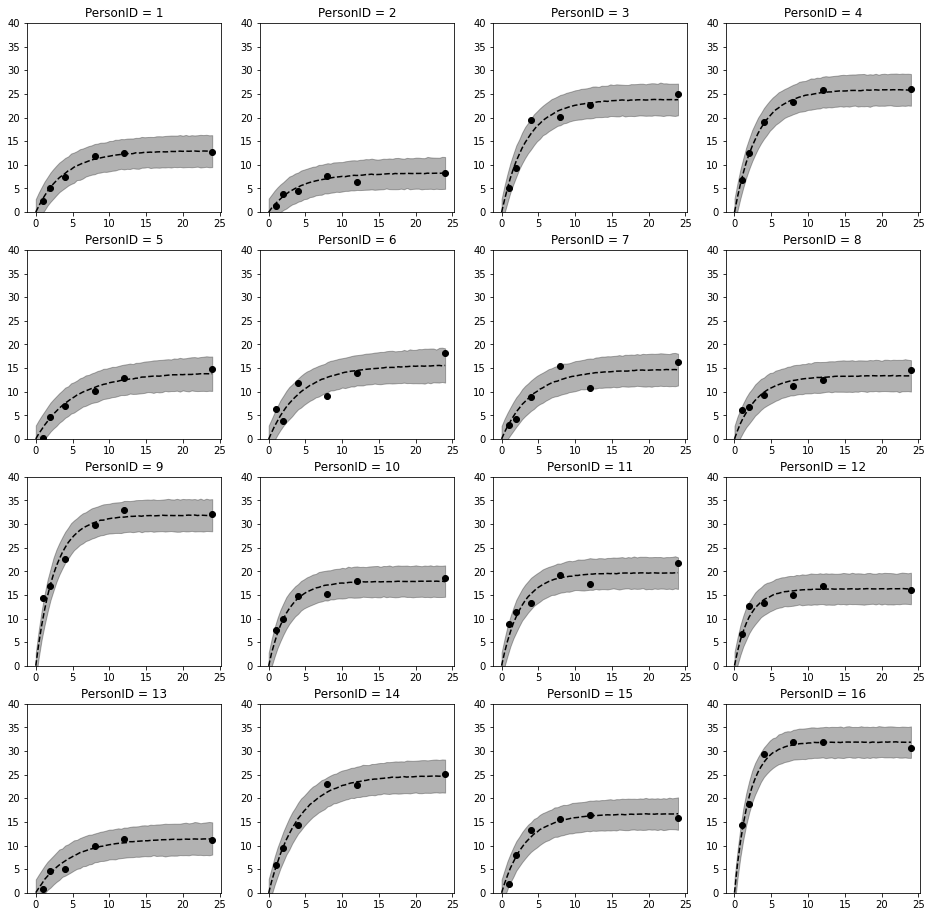

In [13]:
# Fig 8.8

y_new = fit.stan_variable("y_new")
percentiles = np.quantile(y_new, [0.05, 0.5, 0.95], axis=0)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
for i, ax in enumerate(np.ravel(axes)):
    ax.plot(Time, df.iloc[i].values[1:], 'ko')
    ax.plot(Time_new, percentiles[1, i], 'k--')
    ax.fill_between(Time_new, percentiles[0, i], percentiles[2, i], alpha=0.3, color='k')
    ax.set_title(f"PersonID = {i+1}")
    ax.set_ylim(0, 40)  
fig.show()